In [15]:
import torch
from torchmetrics import Accuracy
from helper_functions import plot_decision_boundary
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
device = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42

# 1. Create multi-class data
X_moon, y_moon = make_moons(n_samples=1000,
    noise=0.07, # y labels 
    random_state=RANDOM_SEED
)

X_moon = torch.from_numpy(X_moon).type(torch.float)
y_moon = torch.from_numpy(y_moon).type(torch.float)

X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon, y_moon, test_size=0.2, random_state=RANDOM_SEED)
len(X_moon_train), len(y_moon_train), len(X_moon_test), len(y_moon_test)

(800, 800, 200, 200)

In [16]:
torch_moon_acc = Accuracy(task="binary").to(device)

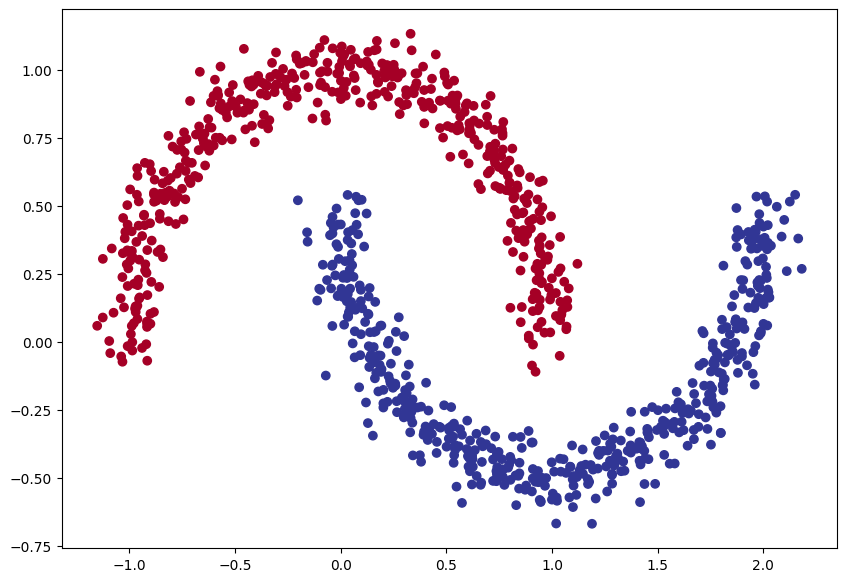

In [17]:
plt.figure(figsize=(10, 7))
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap=plt.cm.RdYlBu);

In [18]:
class MoonModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.moon_layer = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.moon_layer(x)

model_5 = MoonModel(input_features=2, output_features=1, hidden_units=16).to(device)
model_5

MoonModel(
  (moon_layer): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [19]:
moon_loss_fn = nn.BCEWithLogitsLoss()
moon_optimizer = torch.optim.SGD(params=model_5.parameters(),
                                 lr=0.1)

In [20]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

X_moon_train, X_moon_test = X_moon_train.to(device), X_moon_test.to(device)
y_moon_train, y_moon_test = y_moon_train.to(device), y_moon_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_5.train()
    y_logits = model_5(X_moon_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = moon_loss_fn(y_logits, y_moon_train)
    acc = torch_moon_acc(y_pred, y_moon_train)

    moon_optimizer.zero_grad()
    loss.backward()
    moon_optimizer.step()

    model_5.eval()

    with torch.inference_mode():
        test_logits = model_5(X_moon_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = moon_loss_fn(test_logits, y_moon_test)
        test_acc = torch_moon_acc(test_pred, y_moon_test)

        if epoch % (epochs / 10) == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc*100:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%")

Epoch: 0 | Loss: 0.69719, Accuracy: 50.00% | Test loss: 0.69597, Test acc: 50.00%
Epoch: 100 | Loss: 0.33534, Accuracy: 85.38% | Test loss: 0.34346, Test acc: 83.50%
Epoch: 200 | Loss: 0.23406, Accuracy: 89.62% | Test loss: 0.23103, Test acc: 90.00%
Epoch: 300 | Loss: 0.20802, Accuracy: 90.50% | Test loss: 0.20709, Test acc: 89.50%
Epoch: 400 | Loss: 0.17851, Accuracy: 91.88% | Test loss: 0.17785, Test acc: 90.00%
Epoch: 500 | Loss: 0.11244, Accuracy: 95.38% | Test loss: 0.10882, Test acc: 97.00%
Epoch: 600 | Loss: 0.04379, Accuracy: 99.50% | Test loss: 0.03993, Test acc: 100.00%
Epoch: 700 | Loss: 0.02031, Accuracy: 100.00% | Test loss: 0.01767, Test acc: 100.00%
Epoch: 800 | Loss: 0.01218, Accuracy: 100.00% | Test loss: 0.01023, Test acc: 100.00%
Epoch: 900 | Loss: 0.00843, Accuracy: 100.00% | Test loss: 0.00689, Test acc: 100.00%


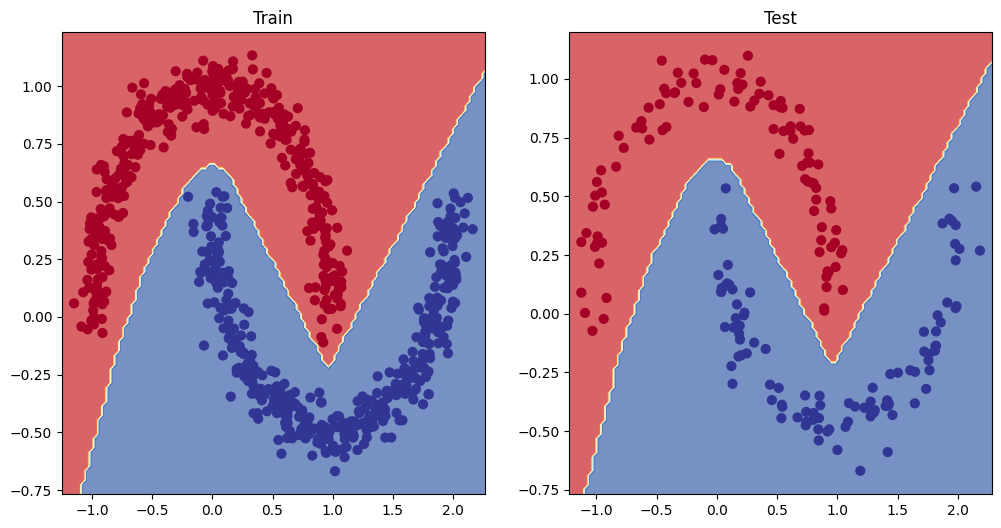

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_moon_train, y_moon_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_moon_test, y_moon_test)